In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import scipy

plt.rcParams["figure.figsize"] = (16,9)

In [2]:
start_date = '2016-01-04T00'
end_date = '2020-03-02T00'

#### Import Price Data

In [3]:
price_data = pd.read_csv("../price data/iDhP/candles_eth-usd_1h.csv")
price_data['timestamp'] = [pd.Timestamp(t) for t in price_data['timestamp']]
price_data['from'] = [pd.Timestamp(t) for t in price_data['from']]
price_data['to'] = [pd.Timestamp(t) for t in price_data['to']]
price_data.head()

,timestamp,exchange,market,base,quote,from,to,open,close,high,low,volume_base,volume_quote
0,2015-05-27 23:00:00,cccagg,eth-usd,eth,usd,2015-05-27 22:00:00,2015-05-27 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-05-28 00:00:00,cccagg,eth-usd,eth,usd,2015-05-27 23:00:00,2015-05-28 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-05-28 01:00:00,cccagg,eth-usd,eth,usd,2015-05-28 00:00:00,2015-05-28 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-28 02:00:00,cccagg,eth-usd,eth,usd,2015-05-28 01:00:00,2015-05-28 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-28 03:00:00,cccagg,eth-usd,eth,usd,2015-05-28 02:00:00,2015-05-28 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0


#### Import Google Trends Data of Various Markets

In [4]:
trends = pd.read_csv("../data connectors/google trends/normalized_data/normalized_Coinbase_2016-01-04-2020-03-02.csv")
trends['timestamp'] = [pd.Timestamp(t) for t in trends['date']]
trends.head()

,date,value,isPartial,interval,keyword,normalized_value,timestamp
0,2016-01-04 00:00:00,64,False,2016-01-04 -> 2016-01-11,Coinbase,0.190711,2016-01-04 00:00:00
1,2016-01-04 01:00:00,60,False,2016-01-04 -> 2016-01-11,Coinbase,0.178791,2016-01-04 01:00:00
2,2016-01-04 02:00:00,55,False,2016-01-04 -> 2016-01-11,Coinbase,0.163892,2016-01-04 02:00:00
3,2016-01-04 03:00:00,51,False,2016-01-04 -> 2016-01-11,Coinbase,0.151973,2016-01-04 03:00:00
4,2016-01-04 04:00:00,50,False,2016-01-04 -> 2016-01-11,Coinbase,0.148993,2016-01-04 04:00:00


### Plotting data

In [5]:
price_data.index = price_data['timestamp']
trends.index = trends['timestamp']

In [6]:
price_data = price_data[start_date:end_date].copy()
trends = trends[start_date:end_date].copy()

In [7]:
print(price_data.shape)
print(trends.shape)

(36457, 13)
(36673, 7)


In [8]:
trends.shape[0]-price_data.shape[0]

216

#### Aggregation to daily level

In [9]:
price_data['day'] = [ts.strftime('%Y-%m-%d') for ts in price_data['timestamp'].to_list()]
price_data = price_data.groupby(by=['day']).mean()
price_data.index = [pd.Timestamp(ts) for ts in price_data.index.to_list()]
price_data['day'] = price_data.index

In [10]:
trends['day'] = [ts.strftime('%Y-%m-%d') for ts in trends['timestamp'].to_list()]
trends = trends.groupby(by=['day']).mean()
trends.index = [pd.Timestamp(ts) for ts in trends.index.to_list()]
trends['day'] = trends.index

### Plot - price open value & wiki page views

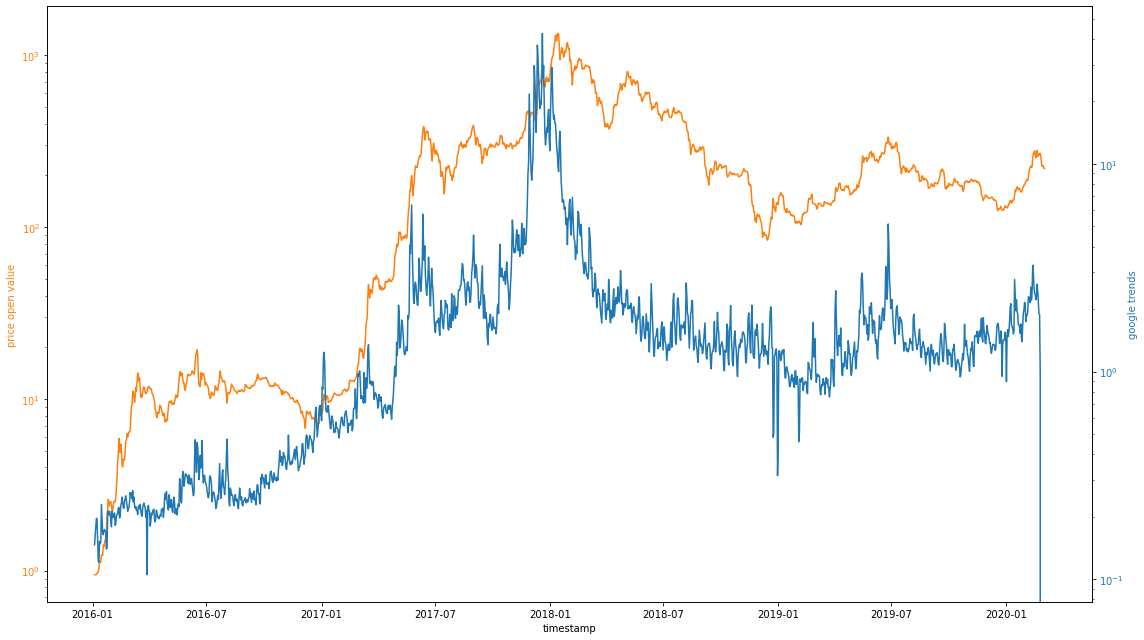

In [28]:
fig, ax1 = plt.subplots()

t = price_data['day'].values

color = 'tab:orange'
ax1.set_xlabel('timestamp')
ax1.set_ylabel('price open value', color=color)
ax1.plot(t, price_data['open'].values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('google trends', color=color)  # we already handled the x-label with ax1
ax2.plot(t, trends['normalized_value'].values, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Testing the Stationarity of the Time Series

source: https://machinelearningmastery.com/time-series-data-stationary-python/

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [12]:
ts = np.array(price_data['open'])
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.349358
p-value: 0.156543
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [13]:
ts = np.array(trends['normalized_value'])
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.882538
p-value: 0.002167
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


### Convert Non-Stationary Time Series to Stationary

In [14]:
ts = np.array(price_data['open'].diff())
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.340711
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


In [15]:
ts = np.array(trends['normalized_value'].diff())
ts = ts[~np.isnan(ts)]

result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.389941
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


both p values are way more smaller than 0.05 -> series are stationary (with difference operation)

### Windowed Time Lagged Cross Correlation (trends<->price)

In [16]:
price_d = price_data.copy()
trends_d = trends.copy()

### Log-Difference Operation

In [17]:
price_d['log_diff_open'] = np.log(price_d['open']).diff()
trends_d['log_diff_trends'] = np.log(trends_d['normalized_value']).diff()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


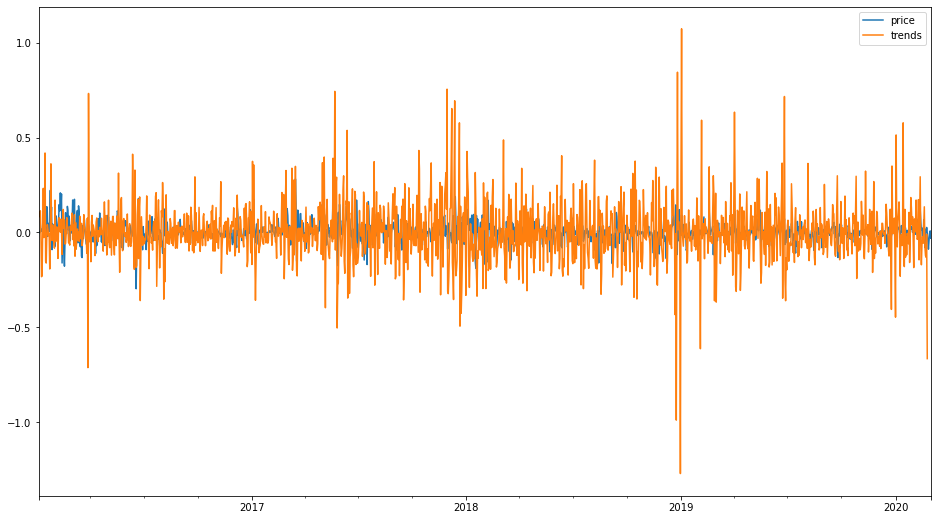

In [18]:
price_d['log_diff_open'].plot(label='price')
trends_d['log_diff_trends'].plot(label='trends')

plt.legend()
plt.show()

### Pearson correlation of log-diff

In [19]:
import time

start = time.time()

data_dict = dict()

lag = 14 # days
window_size = [7,14,30] # days
i=0
for w in window_size:
    for t in range(price_d.shape[0]-lag-w):
        ts_1 = pd.Series(price_d.iloc[t+lag:t+lag+w]['log_diff_open'].values)
        
        for l in range(lag+1):
            ts_2 = pd.Series(trends_d.iloc[t+l:t+l+w]['log_diff_trends'].values)
            try:
                corr = scipy.stats.pearsonr(np.float32(ts_1.values),np.float32(ts_2.values))[0]
            except:
                corr = np.nan
            
            for w_i in range(w):
                try:
                    price_ts = price_d.iloc[t+lag+w_i:t+lag+w_i+1].index.to_list()[0]
                    trends_ts = trends_d.iloc[t+l+w_i:t+l+w_i+1].index.to_list()[0]
                except:
                    price_ts = price_d.iloc[t+lag+w_i:].index.to_list()[0]
                    trends_ts = trends_d.iloc[t+l+w_i:].index.to_list()[0]
                
                data_dict[i] = {'user_activity':'google_trends',
                                'time_offset': t,
                                'timestamp_price':price_ts,
                                'timestamp_wiki':trends_ts,
                                'price':ts_1[w_i],
                                'trends':ts_2[w_i],
                                'window_size':w,
                                'lag':lag-l,
                                'pearson_corr':corr}
                i += 1
    

pearson_correlation_data = pd.DataFrame.from_dict(data_dict, "index")
finish = time.time()
print('data generation took ',str(finish-start),' secs')

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3862: RuntimeWarning: invalid value encountered in subtract
  ym = y.astype(dtype) - ymean


data generation took  750.4584257602692  secs


In [20]:
pearson_correlation_data.dropna(inplace=True)
pcd = pearson_correlation_data.groupby(by=['time_offset','window_size','lag'],as_index=False).mean()

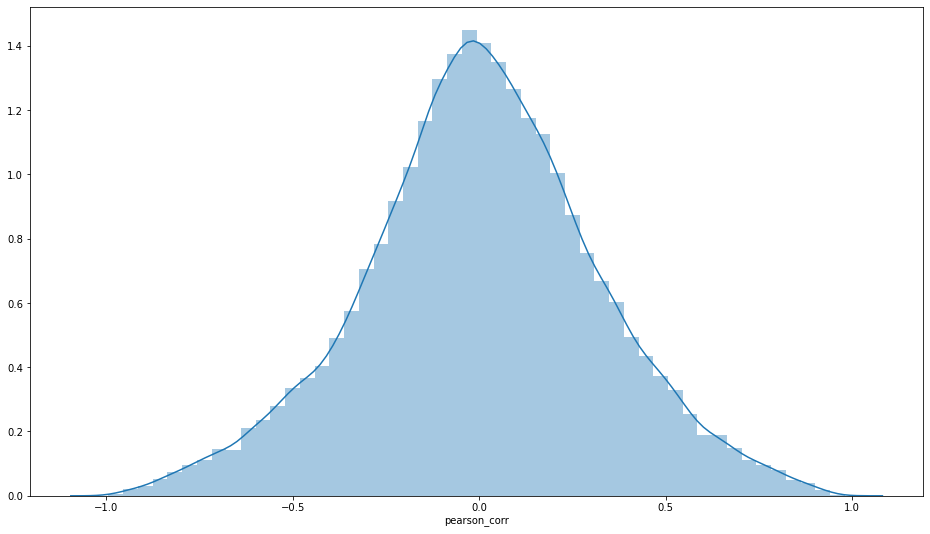

In [21]:
sns.distplot(pcd['pearson_corr'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


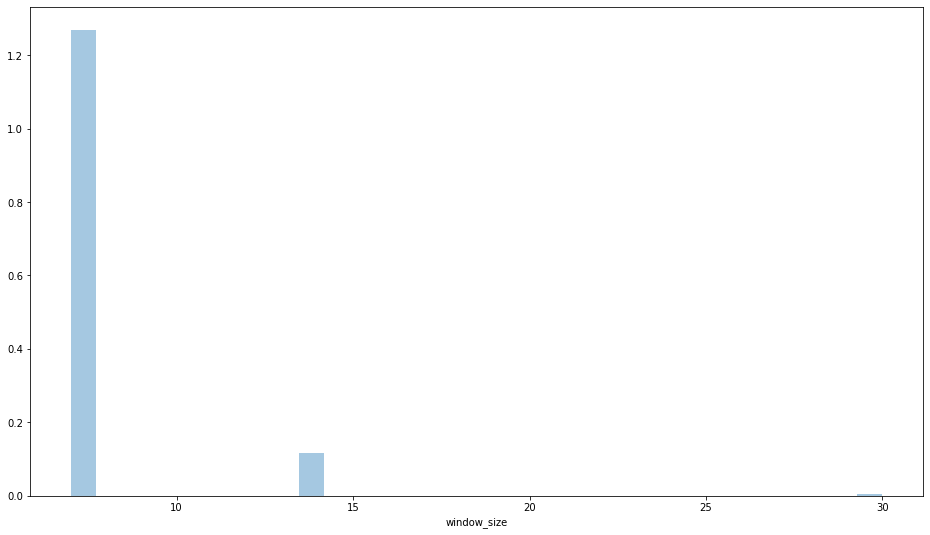

In [22]:
sns.distplot(pcd[pcd['pearson_corr'] > 0.7]['window_size'])

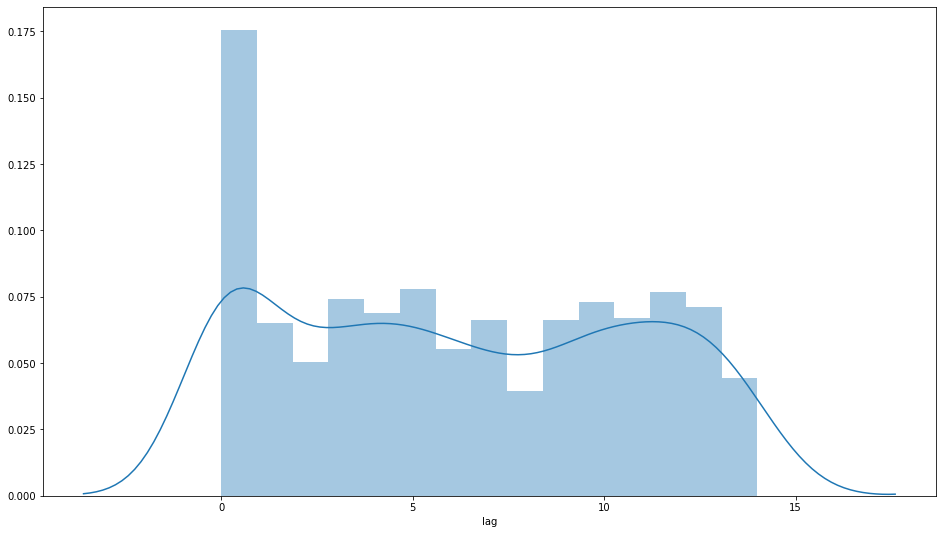

In [23]:
sns.distplot(pcd[pcd['pearson_corr'] > 0.7]['lag'],bins=15)

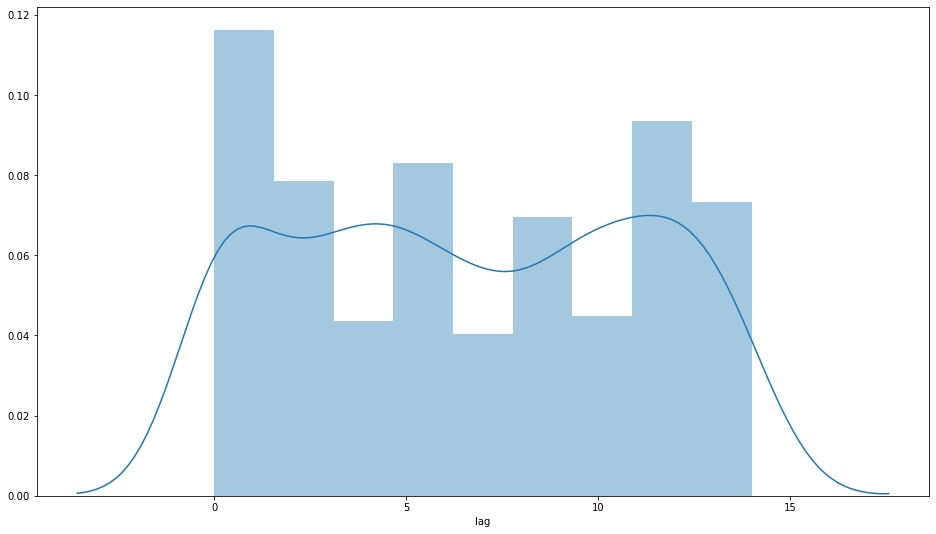

In [24]:
sns.distplot(pcd[(pcd['pearson_corr'] > 0.7) & (pcd['window_size'] == 7)]['lag'])

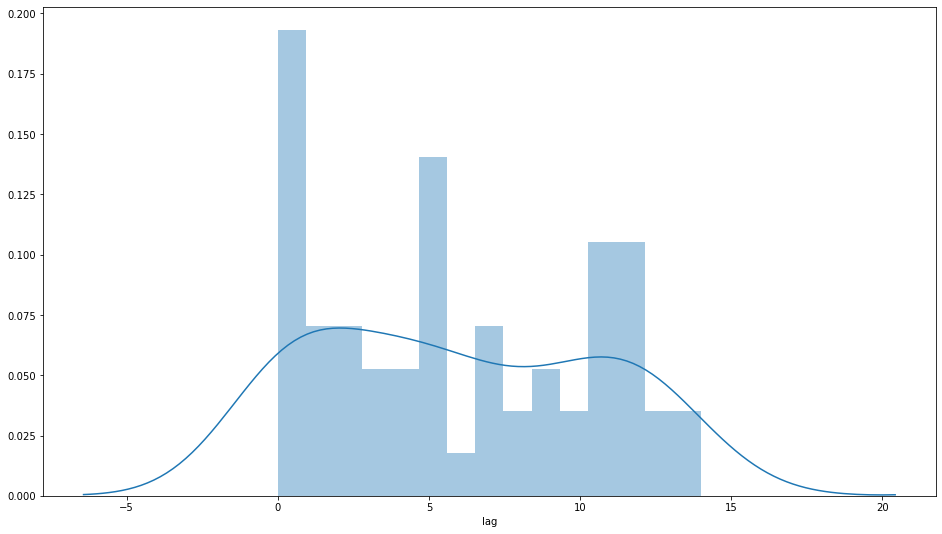

In [25]:
sns.distplot(pcd[(pcd['pearson_corr'] > 0.9) & (pcd['window_size'] == 7)]['lag'],bins=15)

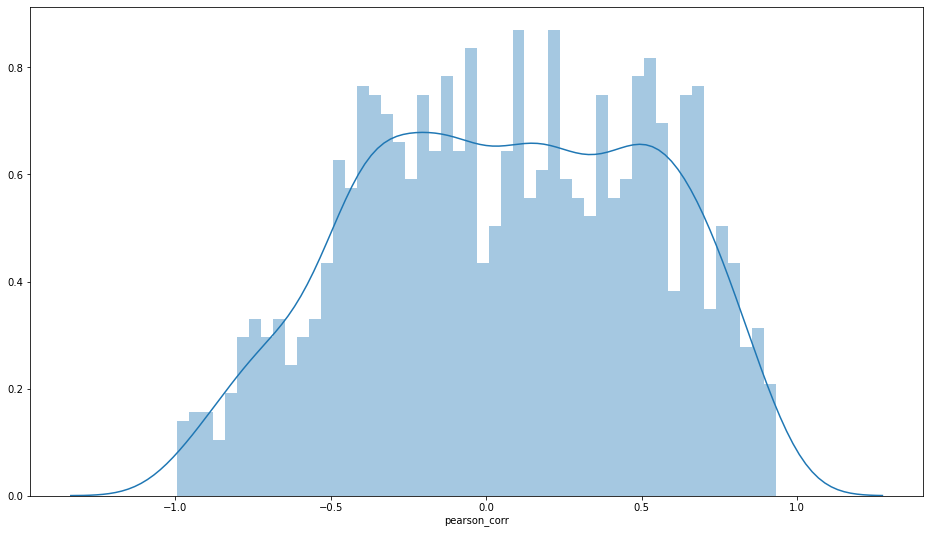

In [26]:
sns.distplot(pcd[(pcd['lag'] == 0) & (pcd['window_size'] == 7)]['pearson_corr'],bins=50)

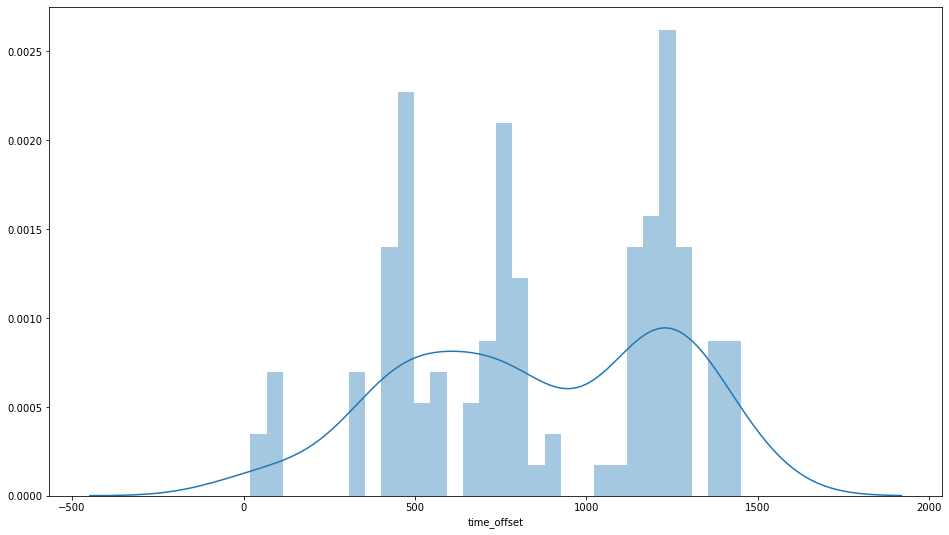

In [27]:
sns.distplot(pcd[(pcd['lag'] == 0) & 
                 (pcd['window_size'] == 7) & 
                 (pcd['pearson_corr'] > 0.7)]['time_offset'],bins=30)